#Descripción del proyecto

Título: Clientes en la banca <br>
Objetivo: Predecir si los clientes de un banco abandonarán o no la entidad bancaria

#Librerias

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import requests
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import re

# IQR/Z score.
from scipy.stats import stats
from scipy.stats import mstats #

# Seleción de variables.
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder#
from sklearn.preprocessing import StandardScaler #
from sklearn.model_selection import learning_curve#
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, classification_report

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Funciones

In [20]:
def histogram_boxplot(data, xlabel=None, title=None, font_scale=2, figsize=(5, 4), bins=None):
    sns.set(font_scale=font_scale)
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.10, .70)}, figsize=figsize)
    sns.boxplot(x=data, ax=ax_box2)  # Especificamos el argumento 'x'
    sns.histplot(x=data, ax=ax_hist2, bins=bins) if bins else sns.histplot(x=data, ax=ax_hist2)
    ax_hist2.axvline(np.mean(data), color='g', linestyle='-')
    ax_hist2.axvline(np.median(data), color='y', linestyle='--')
    if xlabel: ax_hist2.set(xlabel=xlabel)
    if title: ax_box2.set(title=title)
    plt.show()

# Countplot para variables categóricas
def cat_plot(data):
    sns.countplot(x=data)  # Especificamos el argumento 'x'
    plt.show()


def saca_metricas(y1, y2):
    print('Matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('Accuracy')
    print(accuracy_score(y1, y2))
    print('Precision')
    print(precision_score(y1, y2))
    print('Recall')
    print(recall_score(y1, y2))
    print('F1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)

#Cargar el dataset

In [7]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Talento_tech/Customer-Churn-Records.csv')
df=df.set_index('RowNumber')
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
RowNumber,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


#Descripción del dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerId          10000 non-null  int64  
 1   Surname             10000 non-null  object 
 2   CreditScore         10000 non-null  int64  
 3   Geography           10000 non-null  object 
 4   Gender              10000 non-null  object 
 5   Age                 10000 non-null  int64  
 6   Tenure              10000 non-null  int64  
 7   Balance             10000 non-null  float64
 8   NumOfProducts       10000 non-null  int64  
 9   HasCrCard           10000 non-null  int64  
 10  IsActiveMember      10000 non-null  int64  
 11  EstimatedSalary     10000 non-null  float64
 12  Exited              10000 non-null  int64  
 13  Complain            10000 non-null  int64  
 14  Satisfaction Score  10000 non-null  int64  
 15  Card Type           10000 non-null  object 
 16  Point Ear

In [10]:
#Parámetros estadisticos
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,606.515100
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,225.924839
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,5.000000,1000.000000


In [12]:
#Identificando cantidad de valores unicos en cada variable
df.nunique()

,0
CustomerId,10000
Surname,2932
CreditScore,460
Geography,3
Gender,2
Age,70
Tenure,11
Balance,6382
NumOfProducts,4
HasCrCard,2


In [ ]:
#Análisis en las variables categóricas

In [13]:
df.describe(exclude=np.number)

,Surname,Geography,Gender,Card Type
count,10000,10000,10000,10000
unique,2932,3,2,4
top,Smith,France,Male,DIAMOND
freq,32,5014,5457,2507


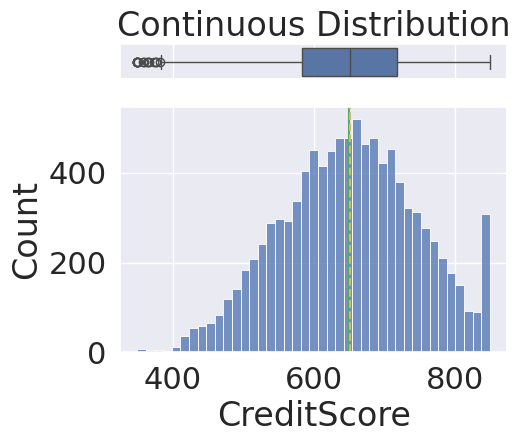

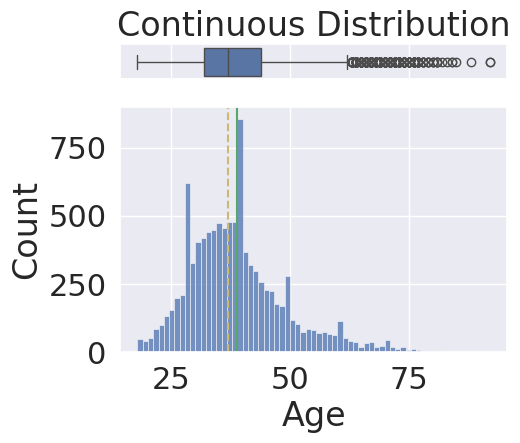

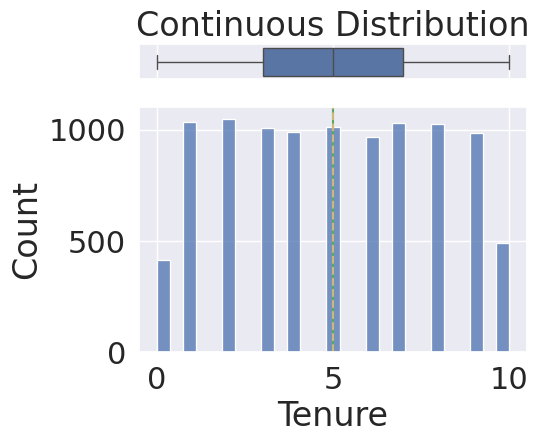

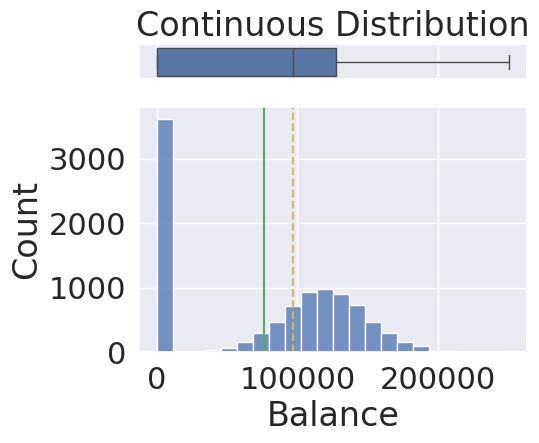

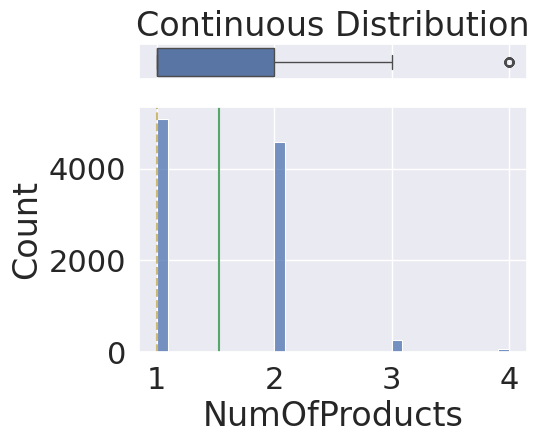

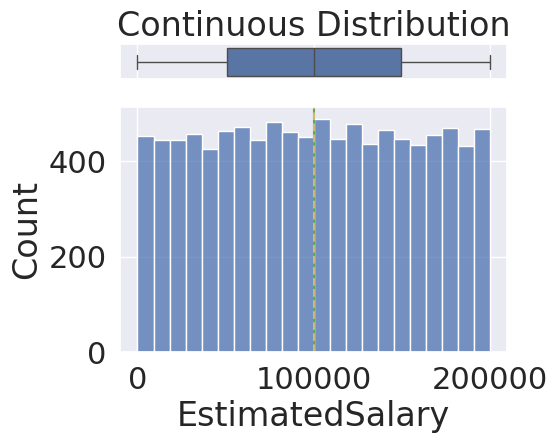

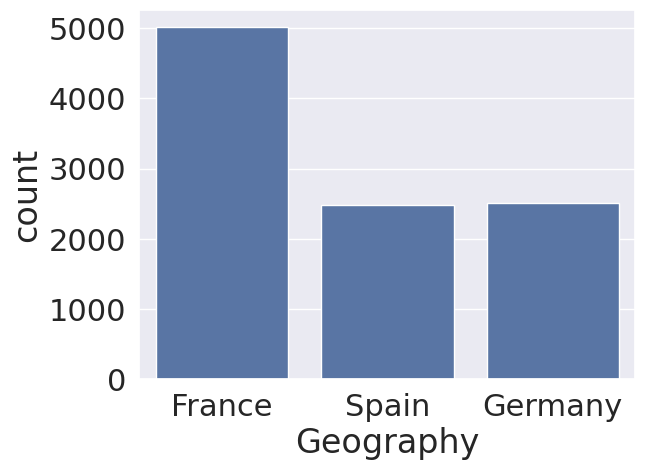

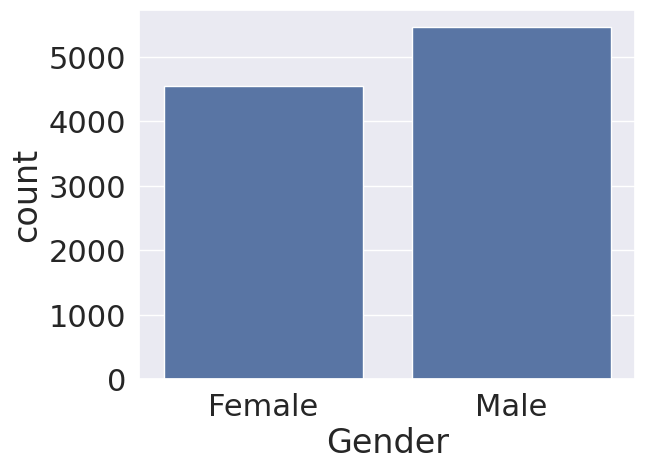

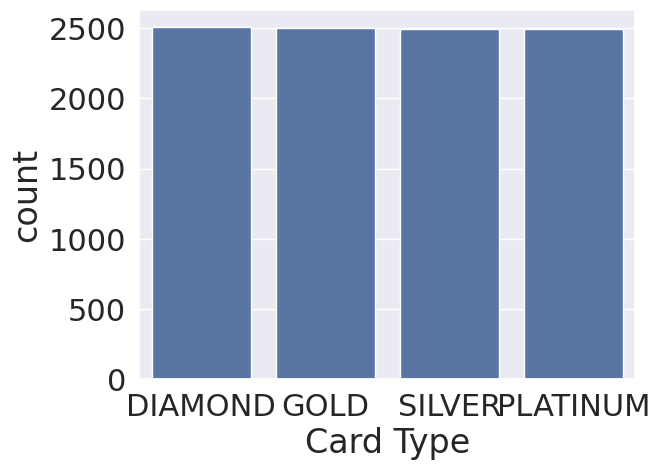

In [19]:
#Distribucion de las variables
columnas = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary",
                "Geography", "Gender", "Card Type"]
for col in columnas:
    if np.issubdtype(df[col].dtype, np.number):
        histogram_boxplot(df[col], xlabel=col, title='Continuous Distribution')
    else:
        cat_plot(df[col])

#Limpieza de datos

In [9]:
df_x=df.drop('Exited', axis=1)  #elimino lavariable objetivo
target = df['Exited'] # Variable objetivo

## Identificación de outliers

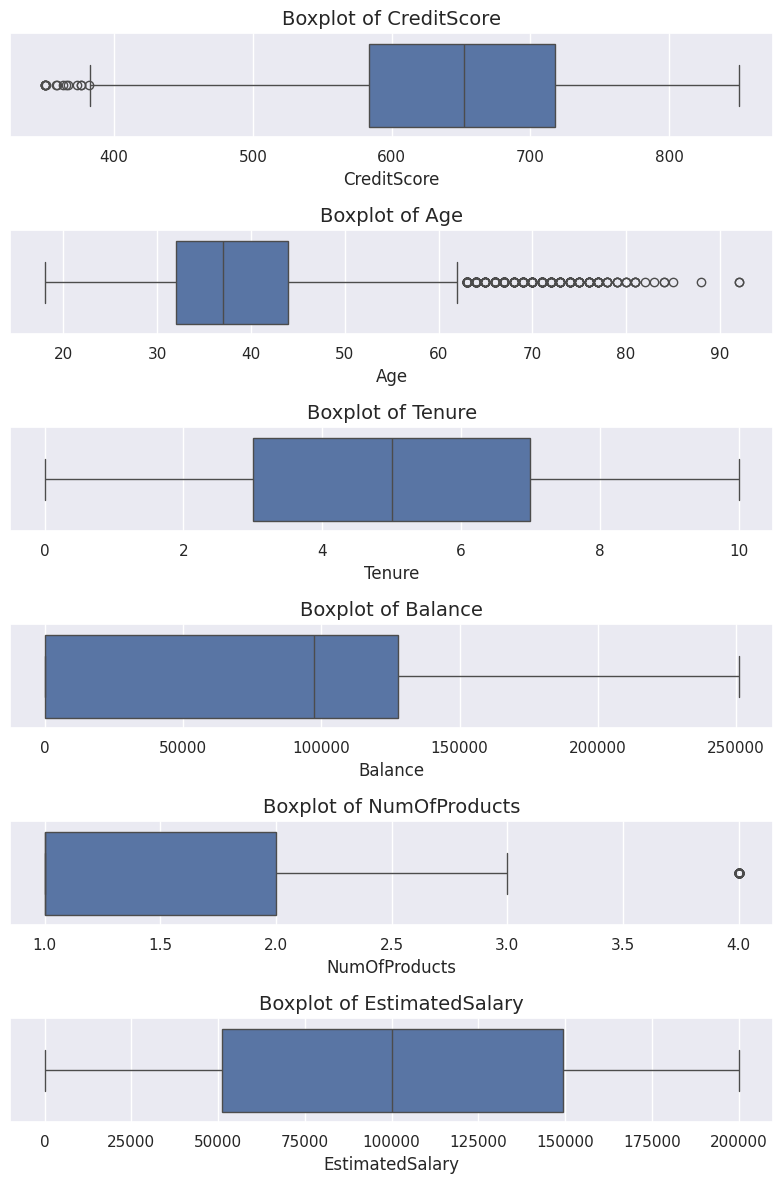

{'CreditScore': {'lower_outliers': 15, 'upper_outliers': 0},
 'Age': {'lower_outliers': 0, 'upper_outliers': 359},
 'Tenure': {'lower_outliers': 0, 'upper_outliers': 0},
 'Balance': {'lower_outliers': 0, 'upper_outliers': 0},
 'NumOfProducts': {'lower_outliers': 0, 'upper_outliers': 60},
 'EstimatedSalary': {'lower_outliers': 0, 'upper_outliers': 0}}

In [10]:
numeric_cols = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"] #columnas númericas

# Creamos subplots para cada una de las columnas numéricas
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(8, 12))
# Creamos boxplots para visualizar los outliers
for i, col in enumerate(numeric_cols):
    sns.boxplot(ax=axes[i], x=df_x[col])
    axes[i].set_title(f'Boxplot of {col}', fontsize=14)
plt.tight_layout()
plt.show()
outliers_data = {}
# Identificamos el número de outliers en cada variable
outliers_count = {}
# Calculamos el número de outliers utilizando IQR
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count[col] = {
        "lower_outliers": df_x[df_x[col] < lower_bound].shape[0],
        "upper_outliers": df_x[df_x[col] > upper_bound].shape[0]
    }
# Mostramos el número de outliers para cada variable
outliers_count

## Corrigiendo los outliers

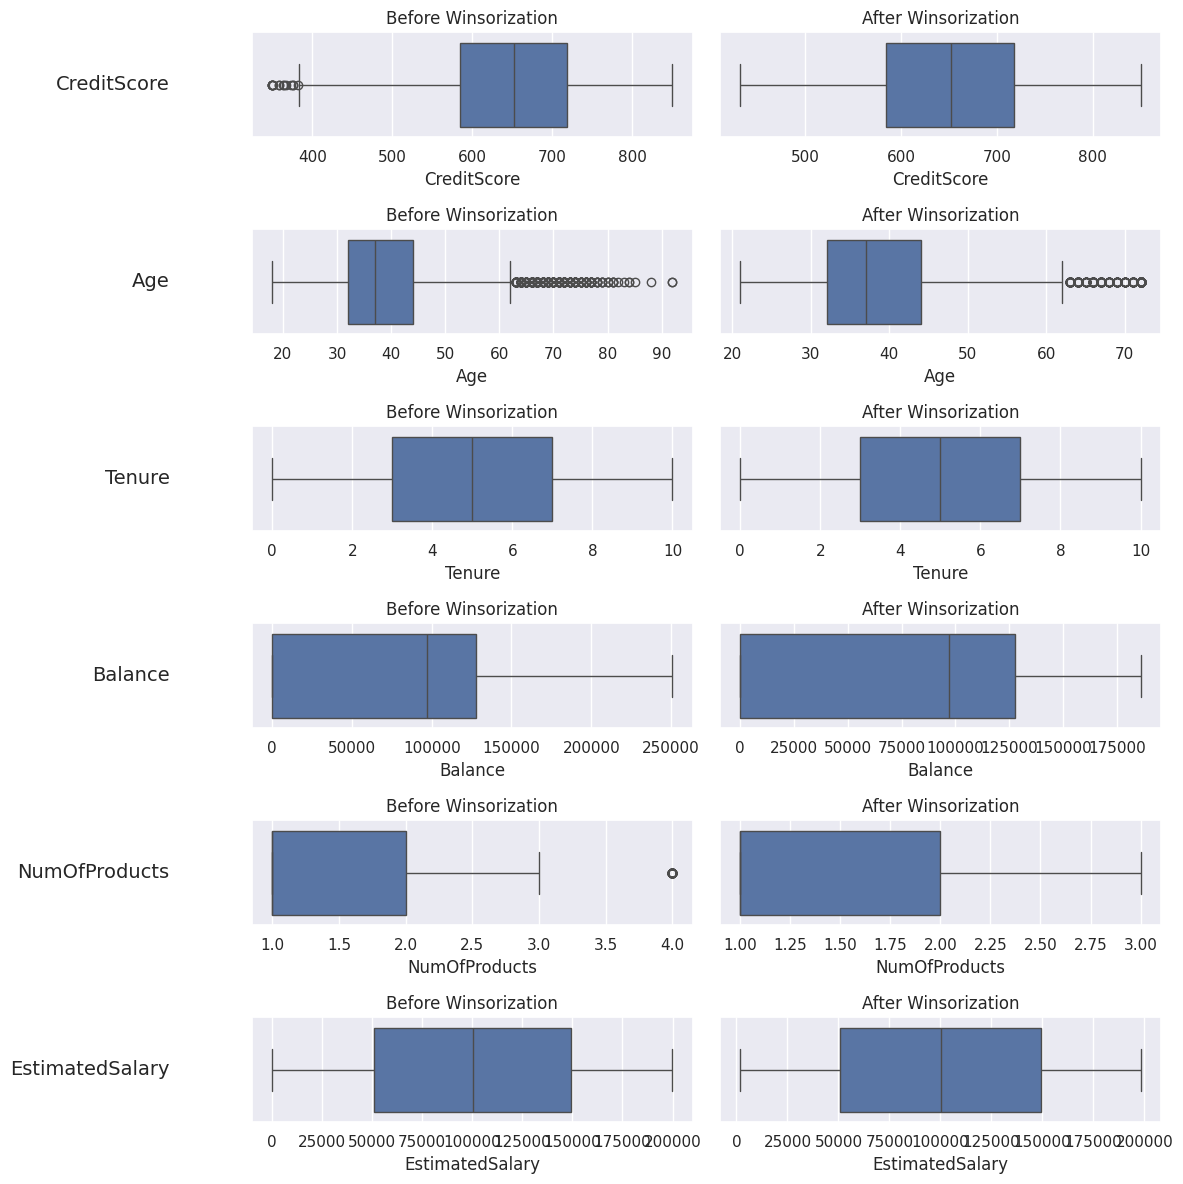

In [11]:
# Para gestionar los outliers
churn1 = df_x.select_dtypes(include=np.number).copy()
churn1cat = df_x.select_dtypes(exclude=np.number).copy()
# Para probar posteriormente sin gestionar los outliers
churn2 = df_x.select_dtypes(include=np.number).copy()
churn2cat = df_x.select_dtypes(exclude=np.number).copy()


# Aplicamos la winsorización para tratar los outliers
for col in numeric_cols:
    churn1[col] = mstats.winsorize(churn1[col], limits=[0.01, 0.01])
# Creamos boxplots para visualizar los datos antes y después de la winsorización
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(12, 12))
for i, col in enumerate(numeric_cols):
    # Boxplot antes de la winsorización
    sns.boxplot(ax=axes[i, 0], x=df_x[col])
    axes[i, 0].set_title(f'Before Winsorization', fontsize=12)
    # Boxplot después de la winsorización
    sns.boxplot(ax=axes[i, 1], x=churn1[col])
    axes[i, 1].set_title(f'After Winsorization', fontsize=12)
    # Añadimos un título para cada fila
    axes[i, 0].set_ylabel(col, fontsize=14, rotation=0, labelpad=50, verticalalignment='center', horizontalalignment='right')
plt.tight_layout()
plt.show()

## Identificación de valores nulos

No se identificaron valores nulos

In [12]:
churn1.apply(lambda x: x.isna().sum()/x.count()*100)  #variables númericas

,0
CustomerId,0.0
CreditScore,0.0
Age,0.0
Tenure,0.0
Balance,0.0
NumOfProducts,0.0
HasCrCard,0.0
IsActiveMember,0.0
EstimatedSalary,0.0
Complain,0.0


In [13]:
churn1cat.apply(lambda x: x.isna().sum()/x.count()*100) #Variables categóricas

,0
Surname,0.0
Geography,0.0
Gender,0.0
Card Type,0.0


## Codificación de variables categóricas con Método One Hot Encoding

In [14]:
df_2=pd.concat([churn1, churn1cat ,target], axis=1)

In [15]:
# Codificación One-hot para las variables 'Geography' y 'Card Type'
churn1_one_hot = pd.get_dummies(df_2, columns=['Geography', 'Card Type'], drop_first=True)
# Codificación de etiquetas para la variable 'Gender'
label_encoder = LabelEncoder()
churn1_one_hot['Gender'] = label_encoder.fit_transform(churn1_one_hot['Gender'])
# Mostrando las primeras filas del dataset transformado
churn1_one_hot.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Point Earned,Surname,Gender,Exited,Geography_Germany,Geography_Spain,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
RowNumber,,,,,,,,,,,,,,,,,,,,
1,15634602,619,42,2,0.00,1,1,1,101348.88,1,2,464,Hargrave,0,1,False,False,False,False,False
2,15647311,608,41,1,83807.86,1,0,1,112542.58,1,3,456,Hill,0,0,False,True,False,False,False
3,15619304,502,42,8,159660.80,3,1,0,113931.57,1,3,377,Onio,0,1,False,False,False,False,False
4,15701354,699,39,1,0.00,2,0,0,93826.63,0,5,350,Boni,0,0,False,False,True,False,False
5,15737888,850,43,2,125510.82,1,1,1,79084.10,0,5,425,Mitchell,0,0,False,True,True,False,False


# División de los datos para modelar y entrenar

In [17]:
X = churn1_one_hot.drop(columns=['Surname', 'Exited'])
y = churn1_one_hot['Exited']

# Partimos el dataset 80% para entrenar y 20% para probar
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y)

#X_train.shape, X_test.shape, y_train.shape, y_test.shap

'0': 6370
'1': 1630 



# Modelos

## Regresión logística  

Matriz de confusión
[[1592    0]
 [ 408    0]]
Accuracy
0.796
Precision
0.0
Recall
0.0
F1
0.0
AUC
0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


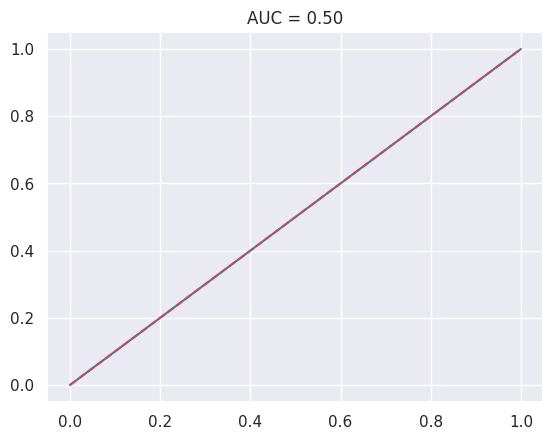

In [21]:
model1a = LogisticRegression().fit(X_train,y_train)# hacemos un .fit() con los datos de entrenamiento
y_pred1a = model1a.predict(X_test)
saca_metricas(y_test, y_pred1a)

In [22]:
print(classification_report(y_test, y_pred1a))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1592
           1       0.00      0.00      0.00       408

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decisión Tree clasificador

Matriz de confusión
[[1591    1]
 [   3  405]]
Accuracy
0.998
Precision
0.9975369458128078
Recall
0.9926470588235294
F1
0.995085995085995
AUC
0.9960094590600059
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



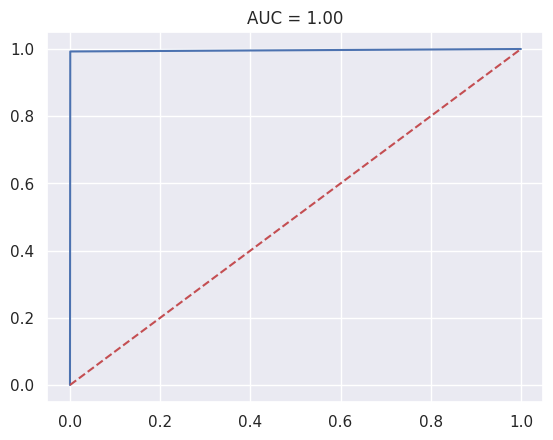

In [26]:
model2a = DecisionTreeClassifier().fit(X_train,y_train)# hacemos un .fit() con los datos de entrenamiento
y_pred2a = model2a.predict(X_test)
saca_metricas(y_test, y_pred2a)
print(classification_report(y_test, y_pred3a))

## Clasificador random forest

Matriz de confusión
[[1591    1]
 [   2  406]]
Accuracy
0.9985
Precision
0.9975429975429976
Recall
0.9950980392156863
F1
0.9963190184049079
AUC
0.9972349492560844
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



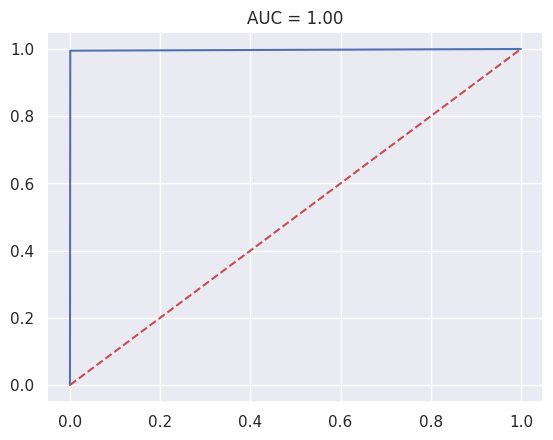

In [25]:
model3a = RandomForestClassifier().fit(X_train,y_train)# hacemos un .fit() con los datos de entrenamiento
y_pred3a = model3a.predict(X_test)
saca_metricas(y_test, y_pred3a)
print(classification_report(y_test, y_pred3a))

## Linear SVC

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

Matriz de confusión
[[1592    0]
 [ 408    0]]
Accuracy
0.796
Precision
0.0
Recall
0.0
F1
0.0
AUC
0.5
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1592
           1       0.00      0.00      0.00       408

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000



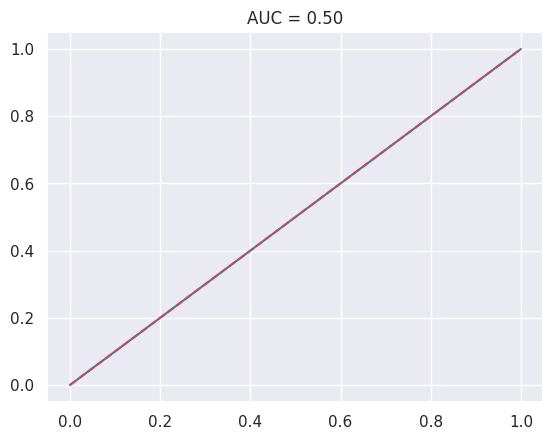

In [27]:
model4a = LinearSVC().fit(X_train,y_train)
y_pred4a = model4a.predict(X_test)
saca_metricas(y_test, y_pred4a)
print(classification_report(y_test, y_pred4a))

## SVC

Matriz de confusión
[[1592    0]
 [ 408    0]]
Accuracy
0.796
Precision
0.0
Recall
0.0
F1
0.0
AUC
0.5
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1592
           1       0.00      0.00      0.00       408

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: Unde

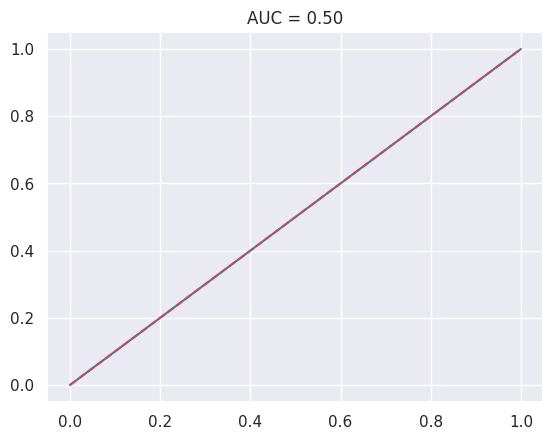

In [28]:
model5a = SVC().fit(X_train,y_train)
y_pred5a = model5a.predict(X_test)
saca_metricas(y_test, y_pred5a)
print(classification_report(y_test, y_pred5a))

## Clasificador XGB

# Desbalanceo de clases

In [29]:
# Verificar que los datos esten uniformes
print("'0': {}".format(sum(y_train== 0)))
print("'1': {} \n".format(sum(y_train== 1)))

'0': 6370
'1': 1630 



La clase 0 (clientes que siguen en la entidad bancaria) está sobrerrepresentada, mientras que la clase 1 (clientes que dejaron la entidad bancaria) tiene menos datos.

In [31]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("'0': {}".format(sum(y_train_smote == 0)))
print("'1': {}".format(sum(y_train_smote == 1)))

'0': 6370
'1': 6370


#Volver a entrenar algunos modelos



## Decision Tree Clasificador

Matriz de confusión
[[1587    5]
 [   3  405]]
Accuracy
0.996
Precision
0.9878048780487805
Recall
0.9926470588235294
F1
0.9902200488997556
AUC
0.9947531776529707
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       0.99      0.99      0.99       408

    accuracy                           1.00      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



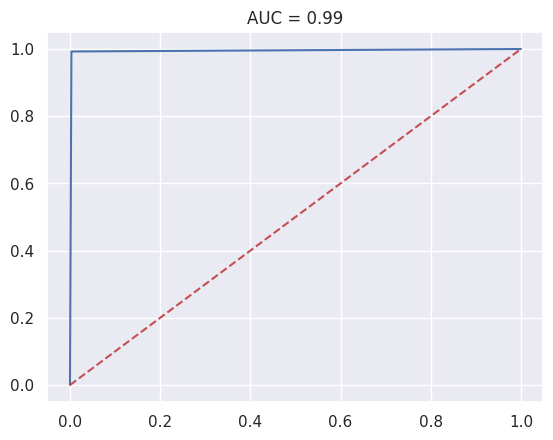

In [33]:
model2a = DecisionTreeClassifier().fit(X_train_smote,y_train_smote)# hacemos un .fit() con los datos de entrenamiento
y_pred2a = model2a.predict(X_test)
saca_metricas(y_test, y_pred2a)
print(classification_report(y_test, y_pred2a))

## Random forest clasificador

Matriz de confusión
[[1591    1]
 [   2  406]]
Accuracy
0.9985
Precision
0.9975429975429976
Recall
0.9950980392156863
F1
0.9963190184049079
AUC
0.9972349492560844
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



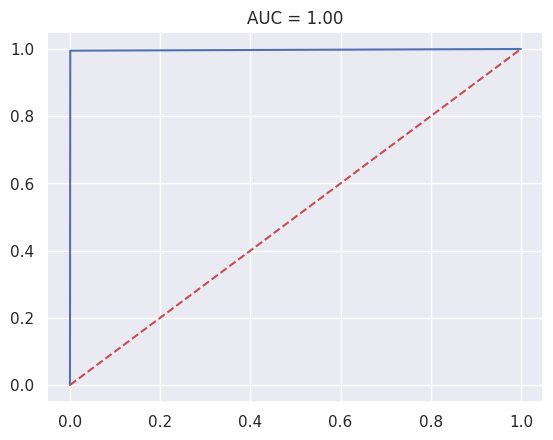

In [34]:
model3a = RandomForestClassifier().fit(X_train_smote,y_train_smote)# hacemos un .fit() con los datos de entrenamiento
y_pred3a = model3a.predict(X_test)
saca_metricas(y_test, y_pred3a)
print(classification_report(y_test, y_pred3a))

# Validación cruzada

In [35]:
cv = cross_val_score(
    model3a,
    X_train_smote,
    y_train_smote,
    scoring = "roc_auc",
    cv = 5
)
print(cv)
print("CV ROC:", cv.mean(), np.std(cv))

[0.99999877 0.99996334 0.9999732  0.99943872 0.99983611]
CV ROC: 0.9998420283461773 0.0002093716152134624


# Importancia de características

In [36]:
imp = {}
for i in range(len(X_train_smote.columns)):
    imp[X_train.columns[i]] = [model3a.feature_importances_[i]]
pd.DataFrame.from_dict(imp, orient="index", columns=["Importance"]).sort_values("Importance", ascending=False).head(10).style.background_gradient()

,Importance
Complain,0.761574
Age,0.057422
IsActiveMember,0.040153
NumOfProducts,0.039250
Gender,0.023100
Geography_Germany,0.018934
Balance,0.011064
Satisfaction Score,0.006662
EstimatedSalary,0.006010
Point Earned,0.005741


# Selección de hipermarámetros con Grid Search

In [40]:
grid_param = {
    'n_estimators': [100,300,500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [16,20,22,24],
    'max_features': ['auto', 'sqrt'],

}
# Esto lo hacemos para que sea estratificado
stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)
# El GridSearchCV ya va a hacer internamente una validación cruzada
model_grid = GridSearchCV(estimator=model3a,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=stratified_kfold,
                     n_jobs=-1)
# Entrenamos el modelo
model_grid.fit(X_train_smote, y_train_smote)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [16, 20, 22, 24],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy')

# Visualizo los mejores parámetros

In [41]:
print(model_grid.best_params_)

{'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 500}


# Obtengo el mejor score

In [42]:
print(model_grid.best_score_)

0.9986656200941916
